In [4]:
# one level up into project folder if needed
import os
#os.chdir("..")

#print("Current working directory:", os.getcwd())


In [5]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

import joblib
import mlflow
import mlflow.sklearn  

from visioninfantnet.utils.ml_utils.metric.classification_metric import get_classification_score

import dagshub
dagshub.init(repo_owner='arunps12', repo_name='VisionInfantNet', mlflow=True)

# quick test run (optional)
with mlflow.start_run():
    mlflow.log_param('parameter name', 'value')
    mlflow.log_metric('metric name', 1)


Accessing as arunps12

Initialized MLflow to track repo "arunps12/VisionInfantNet"

Repository arunps12/VisionInfantNet initialized!

2025/12/07 12:27:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run sassy-ant-843 at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/daaf69786bdb4b1fa7db95d4d17a61db.
2025/12/07 12:27:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


In [6]:
import os

def get_latest_artifact(root_dir="artifacts"):
    """
    Returns full path to the most recent timestamped artifact folder.
    """
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"{root_dir} does not exist.")

    subdirs = [
        os.path.join(root_dir, d)
        for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ]

    if not subdirs:
        raise FileNotFoundError(f"No artifact folders found in {root_dir}.")

    latest = max(subdirs, key=os.path.getmtime)
    return latest

latest_artifact_dir = get_latest_artifact()
print("Latest artifact directory:")
print(latest_artifact_dir)


Latest artifact directory:
artifacts/12_06_2025_14_47_14


In [7]:
feature_root = os.path.join(latest_artifact_dir, "data_transformation", "features")

paths = {
    "egemaps_train": f"{feature_root}/train_compare_features.npy",
    "egemaps_valid": f"{feature_root}/valid_compare_features.npy",

    "boaw_train": f"{feature_root}/train_boaw_features.npy",
    "boaw_valid": f"{feature_root}/valid_boaw_features.npy",

    "fv_train": f"{feature_root}/train_fv_features.npy",
    "fv_valid": f"{feature_root}/valid_fv_features.npy",

    # image embeddings only (we won't use PANNs in this notebook)
    "resnet_train": f"{feature_root}/train_image_embeddings.npy",
    "resnet_valid": f"{feature_root}/valid_image_embeddings.npy",

    "labels_train": f"{feature_root}/train_labels.npy",
    "labels_valid": f"{feature_root}/valid_labels.npy",
}

paths


{'egemaps_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_compare_features.npy',
 'egemaps_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_compare_features.npy',
 'boaw_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_boaw_features.npy',
 'boaw_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_boaw_features.npy',
 'fv_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_fv_features.npy',
 'fv_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_fv_features.npy',
 'resnet_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_image_embeddings.npy',
 'resnet_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_image_embeddings.npy',
 'labels_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_labels.npy',
 'labels_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid

In [8]:
# --- Low-Level Audio Features ---
X_train_egemaps = np.load(paths["egemaps_train"])
X_valid_egemaps = np.load(paths["egemaps_valid"])

X_train_boaw = np.load(paths["boaw_train"])
X_valid_boaw = np.load(paths["boaw_valid"])

X_train_fv = np.load(paths["fv_train"])
X_valid_fv = np.load(paths["fv_valid"])

# --- Image Embeddings (ResNet50) ---
X_train_resnet = np.load(paths["resnet_train"])
X_valid_resnet = np.load(paths["resnet_valid"])

# --- Labels ---
y_train = np.load(paths["labels_train"])
y_valid = np.load(paths["labels_valid"])

print("Loaded all feature tensors successfully!")


Loaded all feature tensors successfully!


In [9]:
print("Shapes:")
print("eGeMAPS:",  X_train_egemaps.shape, X_valid_egemaps.shape)
print("BoAW:",     X_train_boaw.shape,     X_valid_boaw.shape)
print("FisherVec:",X_train_fv.shape,       X_valid_fv.shape)
print("ResNet50:", X_train_resnet.shape,   X_valid_resnet.shape)
print("y_train / y_valid:", y_train.shape, y_valid.shape)


Shapes:
eGeMAPS: (3600, 88) (3580, 88)
BoAW: (3600, 1000) (3580, 1000)
FisherVec: (3600, 640) (3580, 640)
ResNet50: (3600, 2048) (3580, 2048)
y_train / y_valid: (3600,) (3580,)


In [10]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_valid_enc = label_encoder.transform(y_valid)

print("Label encoding mapping:")
for orig, enc in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{orig} → {enc}")


def plot_confusion_matrix_local(cm, class_names, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def impute_train_valid(X_train, X_valid, strategy="median"):
    """Simple helper for imputing train/valid (same logic as previous notebook)."""
    imputer = SimpleImputer(strategy=strategy)
    X_train_imp = imputer.fit_transform(X_train)
    X_valid_imp = imputer.transform(X_valid)
    return X_train_imp, X_valid_imp


Label encoding mapping:
Canonical → 0
Crying → 1
Junk → 2
Laughing → 3
Non-canonical → 4


In [11]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def resample_data(X_train, y_train_enc, method: str):
    """
    Apply class imbalance method to training data only.
    Supported:
        - none
        - class_weights
        - smote
        - smote_tomek
        - undersampling
        - smote_enn
    """
    sample_weight = None
    print(f"[Imbalance] Method = {method}")
    print("  Original class distribution:", Counter(y_train_enc))

    if method == "none":
        return X_train, y_train_enc, None

    elif method == "class_weights":
        classes = np.unique(y_train_enc)
        cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_enc)
        class_weight_dict = dict(zip(classes, cw))
        sample_weight = np.array([class_weight_dict[c] for c in y_train_enc])
        print("  Using class weights:", class_weight_dict)
        return X_train, y_train_enc, sample_weight

    elif method == "smote":
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X_train, y_train_enc)

    elif method == "smote_tomek":
        smote_tomek = SMOTETomek(random_state=42)
        X_res, y_res = smote_tomek.fit_resample(X_train, y_train_enc)

    elif method == "undersampling":
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X_train, y_train_enc)

    elif method == "smote_enn":
        try:
            smote_enn = SMOTEENN(random_state=42)
            X_res, y_res = smote_enn.fit_resample(X_train, y_train_enc)
        except ValueError as e:
            print(f"  [WARN] SMOTEENN failed: {e}")
            print("         Falling back to no resampling.")
            return X_train, y_train_enc, None

    else:
        raise ValueError(f"Unknown imbalance method: {method}")

    print("  New class distribution:", Counter(y_res))
    return X_res, y_res, sample_weight


In [12]:
def run_xgb_experiment_for_feature(
    feature_name: str,
    X_train_raw: np.ndarray,
    X_valid_raw: np.ndarray,
    imbalance_method: str = "none",
    n_estimators: int = 300,
    max_depth: int = 6,
    lr: float = 0.05,
):

    # 1) Impute NaNs
    X_train_imp, X_valid_imp = impute_train_valid(X_train_raw, X_valid_raw, strategy="median")

    # 2) Apply imbalance method on training set only
    X_train_bal, y_train_bal, sample_weight = resample_data(X_train_imp, y_train_enc, method=imbalance_method)

    # 3) Build XGBoost model
    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=lr,
        max_depth=max_depth,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        tree_method="auto",
        n_jobs=-1,
        random_state=42,
    )

    run_name = f"XGB_{feature_name}_{imbalance_method}"
    with mlflow.start_run(run_name=run_name):

        # Fit
        if imbalance_method == "class_weights" and sample_weight is not None:
            model.fit(X_train_bal, y_train_bal, sample_weight=sample_weight)
        else:
            model.fit(X_train_bal, y_train_bal)

        # Predict on validation
        y_pred_enc = model.predict(X_valid_imp)
        y_pred = label_encoder.inverse_transform(y_pred_enc)

        # Metrics
        acc = accuracy_score(y_valid, y_pred)
        metrics = get_classification_score(y_valid, y_pred)

        print(f"\n=== XGBoost on {feature_name} | imbalance={imbalance_method} ===")
        print(f"Accuracy: {acc:.4f}")
        print("Weighted F1:", metrics.f1_score)
        print("Weighted Precision:", metrics.precision_score)
        print("Weighted Recall:", metrics.recall_score)
        print("UAR:", metrics.uar)

        # Confusion matrix
        class_names = list(label_encoder.classes_)
        cm = confusion_matrix(y_valid, y_pred)
        plot_confusion_matrix_local(cm, class_names, f"XGB {feature_name} ({imbalance_method})")

        # Save confusion matrix & log
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        cm_csv = f"cm_xgb_{feature_name}_{imbalance_method}.csv"
        cm_df.to_csv(cm_csv)
        mlflow.log_artifact(cm_csv)

        cm_png = f"cm_xgb_{feature_name}_{imbalance_method}.png"
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"XGB {feature_name} ({imbalance_method})")
        plt.tight_layout()
        plt.savefig(cm_png)
        plt.close()
        mlflow.log_artifact(cm_png)

        # Log params & metrics
        mlflow.log_param("feature_type", feature_name)
        mlflow.log_param("imbalance_method", imbalance_method)
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("learning_rate", lr)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", metrics.f1_score)
        mlflow.log_metric("precision", metrics.precision_score)
        mlflow.log_metric("recall", metrics.recall_score)
        mlflow.log_metric("uar", metrics.uar)

        # Save model locally and log as artifact
        os.makedirs("saved_models", exist_ok=True)
        model_path = f"saved_models/xgb_{feature_name}_{imbalance_method}.pkl"

        import pickle
        with open(model_path, "wb") as f:
            pickle.dump(model, f)

        mlflow.log_artifact(model_path, artifact_path="models")

    return acc, metrics


In [13]:
# --- Combine all four: eGeMAPS + BoAW + FisherVec + ResNet50 ---
X_train_all = np.hstack([X_train_egemaps, X_train_boaw, X_train_fv, X_train_resnet])
X_valid_all = np.hstack([X_valid_egemaps, X_valid_boaw, X_valid_fv, X_valid_resnet])

# --- Combine eGeMAPS + ResNet50 ---
X_train_egemaps_resnet = np.hstack([X_train_egemaps, X_train_resnet])
X_valid_egemaps_resnet = np.hstack([X_valid_egemaps, X_valid_resnet])

# --- Combine eGeMAPS + BoAW + FisherVec ---
X_train_egemaps_boaw_fv = np.hstack([X_train_egemaps, X_train_boaw, X_train_fv])
X_valid_egemaps_boaw_fv = np.hstack([X_valid_egemaps, X_valid_boaw, X_valid_fv])

print("Combined feature shapes:")
print("ALL (eGeMAPS+BoAW+FV+ResNet):", X_train_all.shape, X_valid_all.shape)
print("eGeMAPS+ResNet50:",           X_train_egemaps_resnet.shape, X_valid_egemaps_resnet.shape)
print("eGeMAPS+BoAW+FisherVec:",     X_train_egemaps_boaw_fv.shape, X_valid_egemaps_boaw_fv.shape)


Combined feature shapes:
ALL (eGeMAPS+BoAW+FV+ResNet): (3600, 3776) (3580, 3776)
eGeMAPS+ResNet50: (3600, 2136) (3580, 2136)
eGeMAPS+BoAW+FisherVec: (3600, 1728) (3580, 1728)


[Imbalance] Method = smote
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(1): 1437, np.int64(3): 1437, np.int64(0): 1437, np.int64(4): 1437, np.int64(2): 1437})

=== XGBoost on ALL_eGeMAPS_BoAW_FV_ResNet50 | imbalance=smote ===
Accuracy: 0.6478
Weighted F1: 0.6328358235001535
Weighted Precision: 0.6231120228536284
Weighted Recall: 0.6477653631284916
UAR: 0.38447898067307623


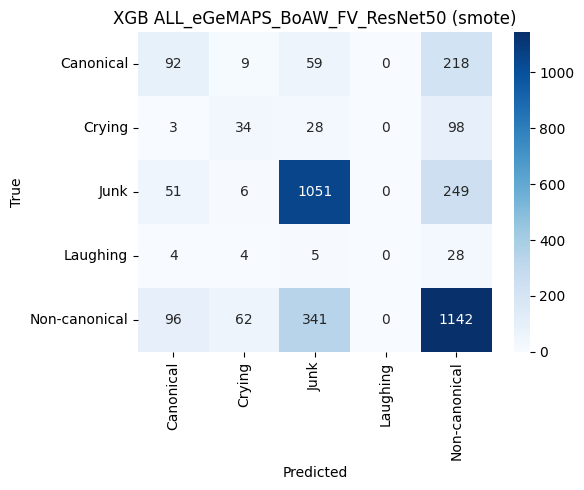

2025/12/07 12:34:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ALL_eGeMAPS_BoAW_FV_ResNet50_smote at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/bdc238b80e5c46c7894afe19028edd05.
2025/12/07 12:34:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


[Imbalance] Method = smote_tomek
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1435, np.int64(1): 1428, np.int64(0): 1415, np.int64(2): 1292, np.int64(4): 1283})

=== XGBoost on ALL_eGeMAPS_BoAW_FV_ResNet50 | imbalance=smote_tomek ===
Accuracy: 0.6394
Weighted F1: 0.6292277836317919
Weighted Precision: 0.6212481365986547
Weighted Recall: 0.6393854748603351
UAR: 0.3934341945249879


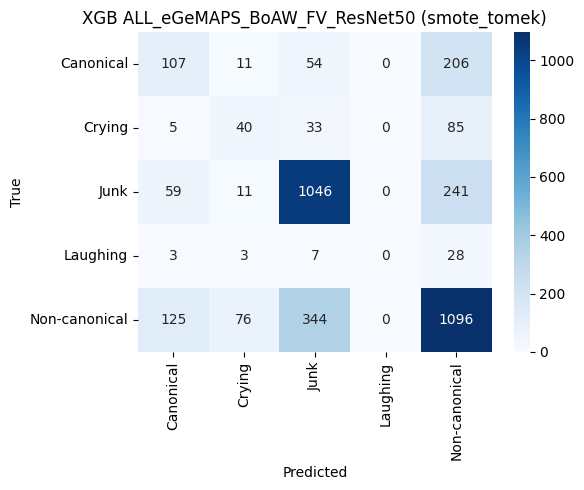

2025/12/07 12:38:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ALL_eGeMAPS_BoAW_FV_ResNet50_smote_tomek at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/07a923785ad74d64a4ffdcf4aa47f89e.
2025/12/07 12:38:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


[Imbalance] Method = undersampling
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(0): 46, np.int64(1): 46, np.int64(2): 46, np.int64(3): 46, np.int64(4): 46})

=== XGBoost on ALL_eGeMAPS_BoAW_FV_ResNet50 | imbalance=undersampling ===
Accuracy: 0.4168
Weighted F1: 0.42988789161559254
Weighted Precision: 0.5931427665579403
Weighted Recall: 0.41675977653631285
UAR: 0.462130201041634


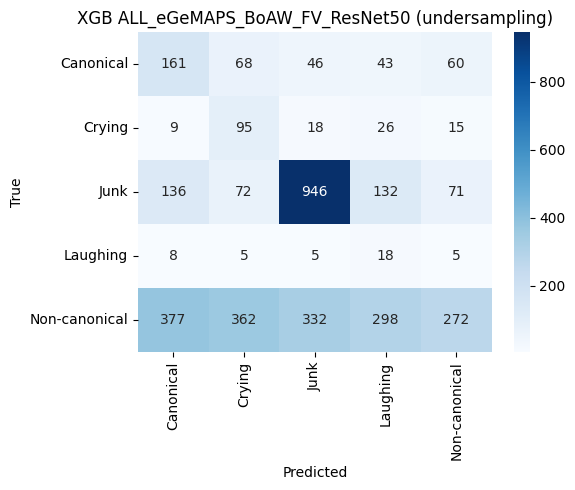

2025/12/07 12:39:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ALL_eGeMAPS_BoAW_FV_ResNet50_undersampling at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/1618ee04337b495b91a0d9f329ddc7ff.
2025/12/07 12:39:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


[Imbalance] Method = smote_enn
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1401, np.int64(1): 1311, np.int64(0): 1104, np.int64(2): 362, np.int64(4): 116})

=== XGBoost on ALL_eGeMAPS_BoAW_FV_ResNet50 | imbalance=smote_enn ===
Accuracy: 0.3885
Weighted F1: 0.37604019908040626
Weighted Precision: 0.651255884017603
Weighted Recall: 0.3885474860335196
UAR: 0.44636119980502376


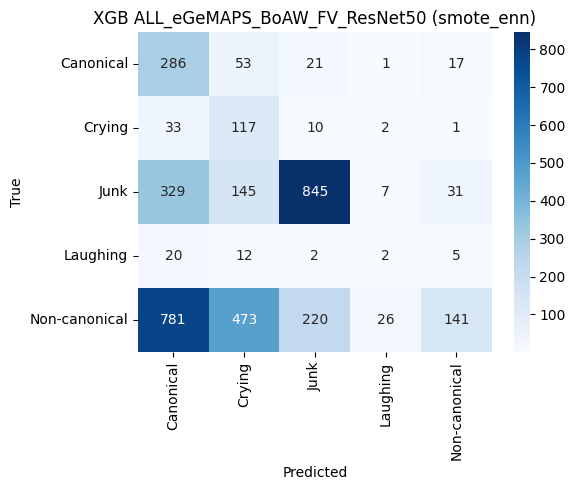

2025/12/07 12:42:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ALL_eGeMAPS_BoAW_FV_ResNet50_smote_enn at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/f87659b278e04c0f8b952a8e72c17f51.
2025/12/07 12:42:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


[Imbalance] Method = smote
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(1): 1437, np.int64(3): 1437, np.int64(0): 1437, np.int64(4): 1437, np.int64(2): 1437})

=== XGBoost on eGeMAPS_ResNet50 | imbalance=smote ===
Accuracy: 0.6500
Weighted F1: 0.6332367860315803
Weighted Precision: 0.6232231852278283
Weighted Recall: 0.65
UAR: 0.3752309104720994


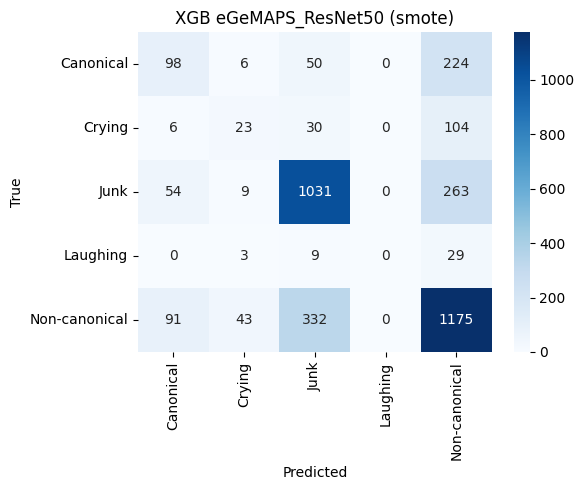

2025/12/07 12:45:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_ResNet50_smote at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/81a156830c844fc0a68e236d00825067.
2025/12/07 12:45:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


[Imbalance] Method = smote_tomek
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1435, np.int64(1): 1428, np.int64(0): 1415, np.int64(2): 1292, np.int64(4): 1283})

=== XGBoost on eGeMAPS_ResNet50 | imbalance=smote_tomek ===
Accuracy: 0.6408
Weighted F1: 0.6286488772840023
Weighted Precision: 0.6196658963530735
Weighted Recall: 0.6407821229050279
UAR: 0.3839326141064163


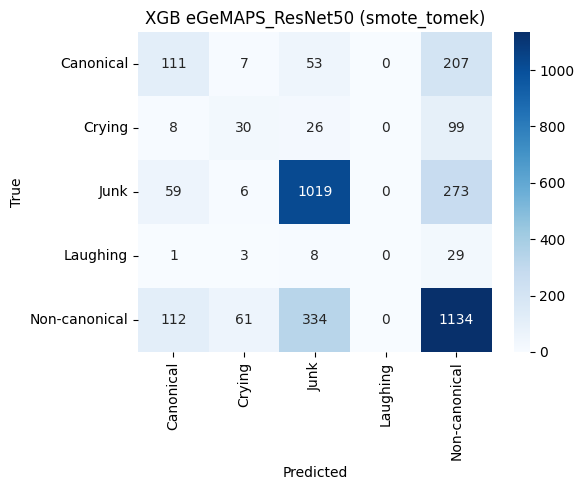

2025/12/07 12:48:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_ResNet50_smote_tomek at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/85914aae569848569815a78707a26ad0.
2025/12/07 12:48:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


[Imbalance] Method = undersampling
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(0): 46, np.int64(1): 46, np.int64(2): 46, np.int64(3): 46, np.int64(4): 46})

=== XGBoost on eGeMAPS_ResNet50 | imbalance=undersampling ===
Accuracy: 0.4056
Weighted F1: 0.41851466884061633
Weighted Precision: 0.5925233567979892
Weighted Recall: 0.40558659217877097
UAR: 0.45063305852520286


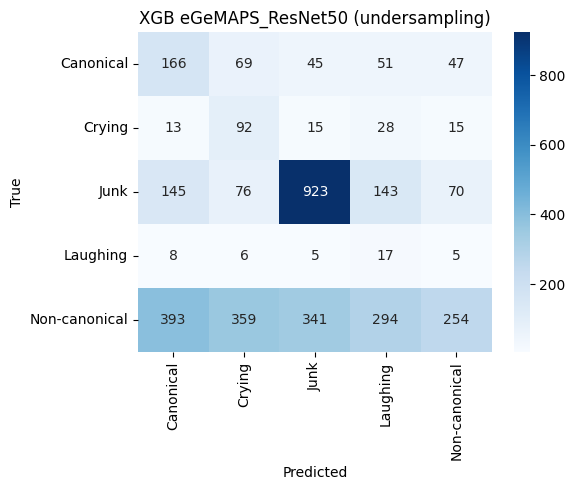

2025/12/07 12:48:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_ResNet50_undersampling at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/0e511b0dee7041e59cb12a683cfc791d.
2025/12/07 12:48:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


[Imbalance] Method = smote_enn
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1401, np.int64(1): 1311, np.int64(0): 1104, np.int64(2): 362, np.int64(4): 116})

=== XGBoost on eGeMAPS_ResNet50 | imbalance=smote_enn ===
Accuracy: 0.3880
Weighted F1: 0.37796655901185866
Weighted Precision: 0.6658421608330864
Weighted Recall: 0.38798882681564245
UAR: 0.45288834159820385


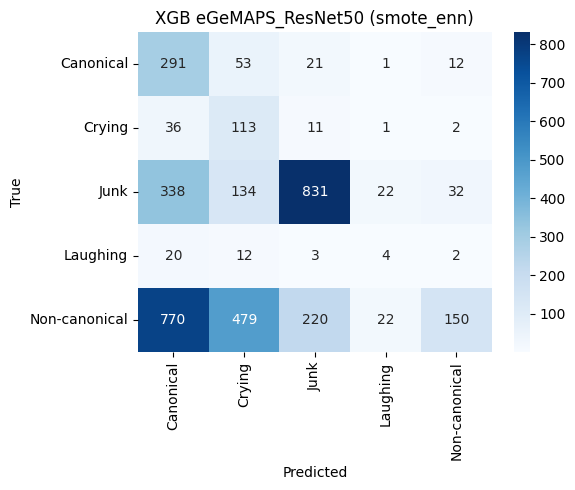

2025/12/07 12:50:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_ResNet50_smote_enn at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/12916006cef9419986a5824e8eeb44ce.
2025/12/07 12:50:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


[Imbalance] Method = smote
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(1): 1437, np.int64(3): 1437, np.int64(0): 1437, np.int64(4): 1437, np.int64(2): 1437})

=== XGBoost on eGeMAPS_BoAW_FisherVec | imbalance=smote ===
Accuracy: 0.6310
Weighted F1: 0.6283689185634324
Weighted Precision: 0.6269080527074371
Weighted Recall: 0.6310055865921788
UAR: 0.4126231274619355


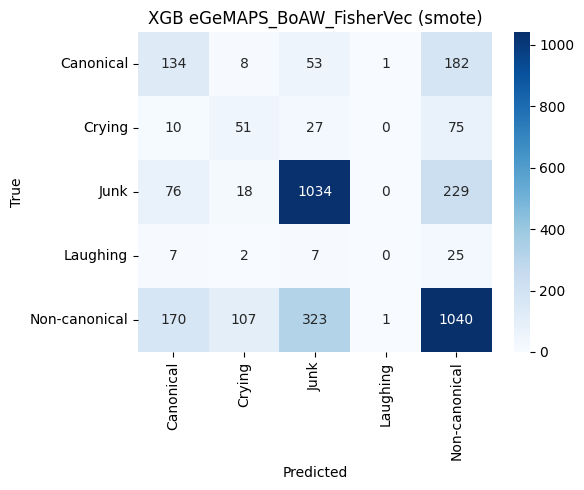

2025/12/07 12:52:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_BoAW_FisherVec_smote at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/a460e4f6551341028d5684b02e755e6b.
2025/12/07 12:52:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


[Imbalance] Method = smote_tomek
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1435, np.int64(1): 1428, np.int64(0): 1415, np.int64(2): 1292, np.int64(4): 1283})

=== XGBoost on eGeMAPS_BoAW_FisherVec | imbalance=smote_tomek ===
Accuracy: 0.6204
Weighted F1: 0.6210513813856019
Weighted Precision: 0.623825119213318
Weighted Recall: 0.620391061452514
UAR: 0.4078642699434013


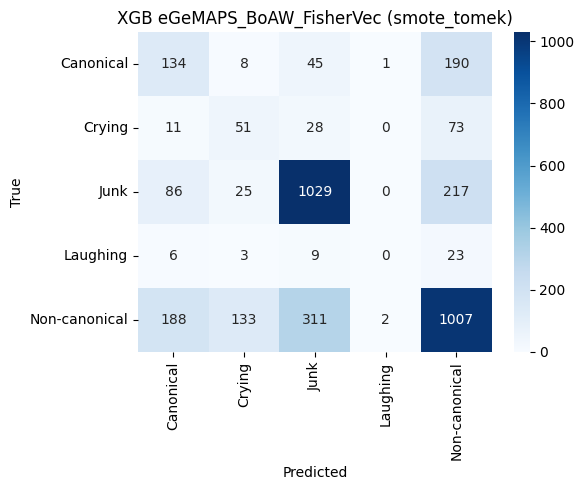

2025/12/07 12:53:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_BoAW_FisherVec_smote_tomek at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/3208a989140a422e9e5290bac88f7a45.
2025/12/07 12:53:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


[Imbalance] Method = undersampling
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(0): 46, np.int64(1): 46, np.int64(2): 46, np.int64(3): 46, np.int64(4): 46})

=== XGBoost on eGeMAPS_BoAW_FisherVec | imbalance=undersampling ===
Accuracy: 0.4092
Weighted F1: 0.43348433947677156
Weighted Precision: 0.576637895241902
Weighted Recall: 0.4092178770949721
UAR: 0.4108079453650656


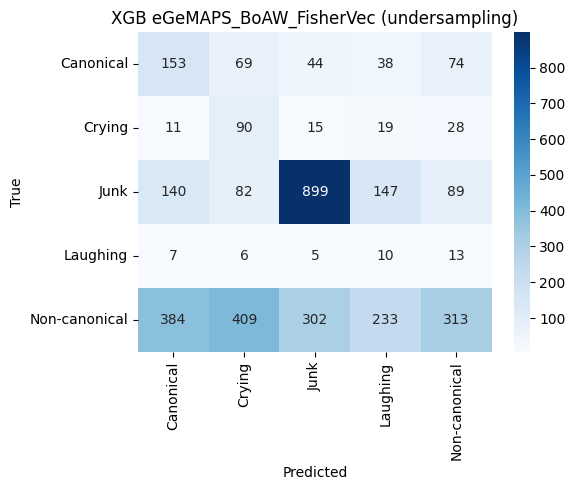

2025/12/07 12:54:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_BoAW_FisherVec_undersampling at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/b4cb3624f2954e4ca4f56750aef434a8.
2025/12/07 12:54:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


[Imbalance] Method = smote_enn
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1401, np.int64(1): 1311, np.int64(0): 1104, np.int64(2): 360, np.int64(4): 116})

=== XGBoost on eGeMAPS_BoAW_FisherVec | imbalance=smote_enn ===
Accuracy: 0.3791
Weighted F1: 0.3674376242973318
Weighted Precision: 0.658829103360028
Weighted Recall: 0.37905027932960894
UAR: 0.44233605337557547


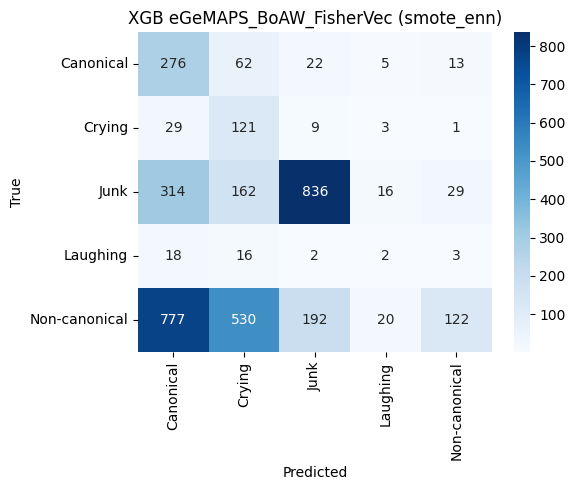

2025/12/07 12:55:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_eGeMAPS_BoAW_FisherVec_smote_enn at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/71dcf5af530341eea910a3d07d2b39b1.
2025/12/07 12:55:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


,feature_combo,imbalance_method,accuracy,f1,precision,recall,uar
0,ALL_eGeMAPS_BoAW_FV_ResNet50,smote,0.647765,0.632836,0.623112,0.647765,0.384479
1,ALL_eGeMAPS_BoAW_FV_ResNet50,smote_tomek,0.639385,0.629228,0.621248,0.639385,0.393434
2,ALL_eGeMAPS_BoAW_FV_ResNet50,undersampling,0.416760,0.429888,0.593143,0.416760,0.462130
3,ALL_eGeMAPS_BoAW_FV_ResNet50,smote_enn,0.388547,0.376040,0.651256,0.388547,0.446361
4,eGeMAPS_ResNet50,smote,0.650000,0.633237,0.623223,0.650000,0.375231
5,eGeMAPS_ResNet50,smote_tomek,0.640782,0.628649,0.619666,0.640782,0.383933
6,eGeMAPS_ResNet50,undersampling,0.405587,0.418515,0.592523,0.405587,0.450633
7,eGeMAPS_ResNet50,smote_enn,0.387989,0.377967,0.665842,0.387989,0.452888
8,eGeMAPS_BoAW_FisherVec,smote,0.631006,0.628369,0.626908,0.631006,0.412623
9,eGeMAPS_BoAW_FisherVec,smote_tomek,0.620391,0.621051,0.623825,0.620391,0.407864


In [14]:
combined_feature_map = {
    "ALL_eGeMAPS_BoAW_FV_ResNet50": (X_train_all,            X_valid_all),
    "eGeMAPS_ResNet50":             (X_train_egemaps_resnet, X_valid_egemaps_resnet),
    "eGeMAPS_BoAW_FisherVec":       (X_train_egemaps_boaw_fv, X_valid_egemaps_boaw_fv),
}

imbalance_methods = [
    "smote",
    "smote_tomek",
    "undersampling",
    "smote_enn",
]

results_table = []

for combo_name, (Xtr, Xval) in combined_feature_map.items():
    for imb in imbalance_methods:
        acc, metrics = run_xgb_experiment_for_feature(
            feature_name=combo_name,
            X_train_raw=Xtr,
            X_valid_raw=Xval,
            imbalance_method=imb,
        )
        results_table.append({
            "feature_combo": combo_name,
            "imbalance_method": imb,
            "accuracy": acc,
            "f1": metrics.f1_score,
            "precision": metrics.precision_score,
            "recall": metrics.recall_score,
            "uar": metrics.uar,
        })

results_df = pd.DataFrame(results_table)
results_df
